<a target="_blank" href="https://colab.research.google.com/github/porteratzo/foundation_tutorial/blob/main/intro.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!git clone https://github.com/porteratzo/foundation_tutorial

In [ ]:

!pip install gdown
!gdown --id 1hsjWKxAb8ibWNhAQ2sMcDNucw3Ios89d

# Introducción a Visión por Computadora con modelos DINO

Este cuaderno es una introducción a la visión por computadora y a modelos fundacionales (DINO). Está diseñado para estudiantes y está dividido en tres partes:

1. Conceptos básicos y preprocesado de imágenes.
2. Extracción y visualización de características y mapas de atención usando modelos DINO.
3. Un ejemplo práctico de búsqueda por imagen (image retrieval) utilizando el token CLS.

Objetivos de aprendizaje:
- Entender el flujo básico para trabajar con imágenes en PyTorch y PIL.
- Aprender a extraer representaciones (features) de modelos DINO y visualizar mapas de atención.
- Implementar un ejemplo sencillo de búsqueda de imágenes usando similitud de características.


In [2]:
import random
from glob import glob

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from scipy.ndimage import median_filter as medi
from scipy.ndimage import sobel
from sklearn.metrics.pairwise import cosine_similarity
from torch import Tensor
from tqdm import tqdm
from transformers import AutoModel

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
PATCH_SIZE = 16
IMAGE_SIZE = 320

# Detectar dispositivo disponible (GPU si existe)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
def resize_transform(mask_image: Image) -> torch.Tensor:
    # Redimensiona la imagen al tamaño requerido por el modelo de AI
    return TF.to_tensor(TF.resize(mask_image, (IMAGE_SIZE, IMAGE_SIZE)))

def extract_classification_token(image, normalize: bool = True) -> Tensor:
    # Extrae el token CLS (vector de la imagen)
    with torch.inference_mode():
        image = image.convert("RGB") # [h,w,3]
        image_resized = resize_transform(image) # [h',w',3]
        image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        image_resized = image_resized.unsqueeze(0).to(device) # [1,h',w',3]
        outputs = model(image_resized, output_hidden_states=True) # [1,cls+register+patches,D]
        cls_token = outputs.last_hidden_state[:, 0, :]
        if normalize:
            cls_token = F.normalize(cls_token, p=2, dim=1)
        return cls_token.squeeze().detach().cpu()

In [4]:
def get_seg(frame, current_pred_np, color=(255, 0, 0)):
    # Superpone una predicción binaria sobre la imagen original
    segmented_frame = frame.copy()
    original_width, original_height = frame.size
    current_pred_np = Image.fromarray((current_pred_np).astype(np.uint8)).resize((original_width, original_height), resample=Image.NEAREST)
    current_pred_np = np.array(current_pred_np)

    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    opened = cv2.morphologyEx(current_pred_np, cv2.MORPH_OPEN, kernel)
    current_pred_np = opened

    segmented_frame = np.array(segmented_frame)
    overlay = current_pred_np[:, :, None] * np.array(color, dtype=np.uint8)
    segmented_frame = np.clip(segmented_frame.astype(np.int32) + overlay.astype(np.int32), 0, 255).astype(np.uint8)
    return segmented_frame

def jet_plot(frame, sims):
    # Visualiza una máscara de similitud con mapa 'jet' sobre la imagen
    colormap = cm.get_cmap("jet")
    original_width, original_height = frame.size
    colored_sims = colormap(sims.cpu().numpy())[:, :, :3]
    colored_sims = (colored_sims * 255).astype(np.uint8)
    colored_sims_pil = Image.fromarray(colored_sims).resize((original_width, original_height), resample=Image.NEAREST)
    blended = Image.blend(frame.convert("RGBA"), colored_sims_pil.convert("RGBA"), alpha=0.5)
    return blended

In [5]:
# Cargar el modelo (versión pequeña para clase)
model = AutoModel.from_pretrained("facebook/dinov2-small", output_attentions=True)
model.to(device)
model.eval()
print("Modelo cargado y puesto en modo evaluación.")

Modelo cargado y puesto en modo evaluación.


In [6]:
# Cargar imágenes desde la carpeta 'data' (estructura: data/<clase>/*.jpg)
data_dir = "data"
image_dict = {}
for dir in glob(f"{data_dir}/*"):
    image_dict[dir] = []
    for img_path in glob(f"{dir}/*.jpg"):
        frame = Image.open(img_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
        image_dict[dir].append(frame)
    print(f"Cargadas {len(image_dict[dir])} imágenes en {dir}")

Cargadas 50 imágenes en data/crocodile
Cargadas 34 imágenes en data/garfield
Cargadas 62 imágenes en data/chair
Cargadas 47 imágenes en data/cougar_body
Cargadas 46 imágenes en data/beaver


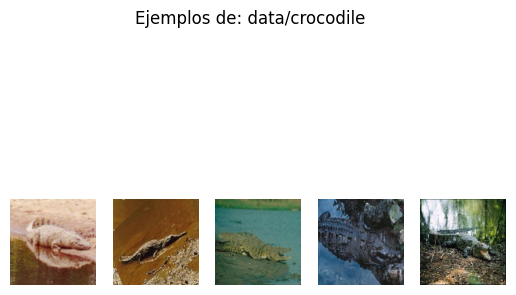

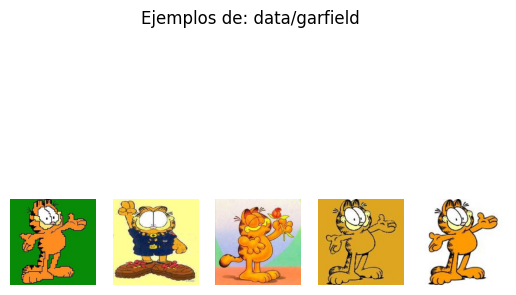

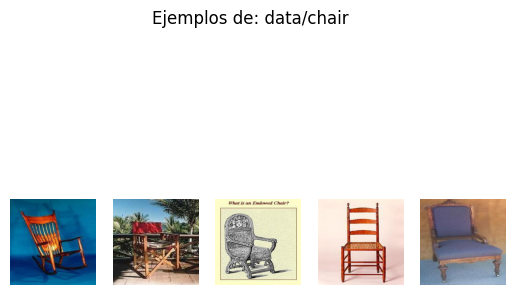

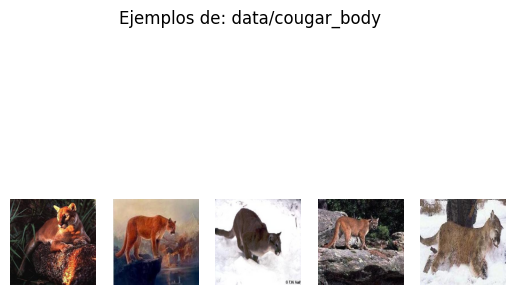

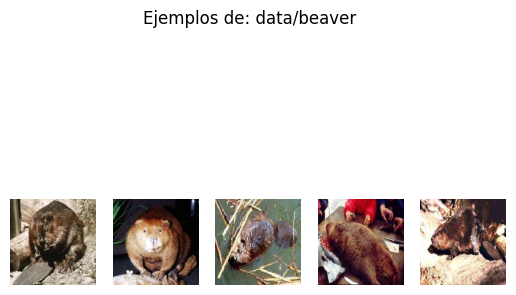

In [7]:
# Visualizar algunas imágenes por categoría
for dir, images in image_dict.items():
    #plt.figure(figsize=(20, 10))
    for i, img in enumerate(images[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Ejemplos de: {dir}")
    plt.show()

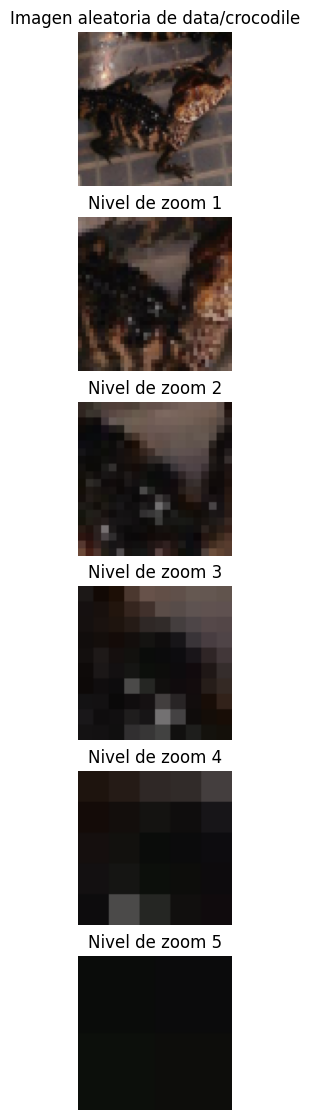

Tamano de cuadro con zoom: 2 2 3
[[[10 12 10]
  [11 11 12]]

 [[12 15 11]
  [13 13 11]]]


In [8]:
# Demostración de zoom iterativo en una imagen aleatoria
random_dir = random.choice(list(image_dict.keys()))
images = image_dict[random_dir]
_frame: Image.Image = random.choice(images).resize((IMAGE_SIZE // 4, IMAGE_SIZE // 4))
number_of_zooms = 6
plt.figure(figsize=(8, 14))
plt.subplot(number_of_zooms, 1, 1)
plt.imshow(_frame)
plt.axis("off")
plt.title(f"Imagen aleatoria de {random_dir}")
for i in range(1, number_of_zooms):
    width, height = _frame.size
    new_width, new_height = width // (2**i), height // (2**i)
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    zoomed_frame = _frame.crop((left, top, right, bottom)).resize((width, height), resample=Image.NEAREST)
    plt.subplot(number_of_zooms, 1, i + 1)
    plt.imshow(zoomed_frame)
    plt.axis("off")
    plt.title(f"Nivel de zoom {i}")
plt.show()
print("Tamano de cuadro con zoom:", new_width, new_height, 3)
print(np.asarray(_frame.crop((left, top, right, bottom))))

![Local Image](./arch.png)

![Local Image](./sobel.png)

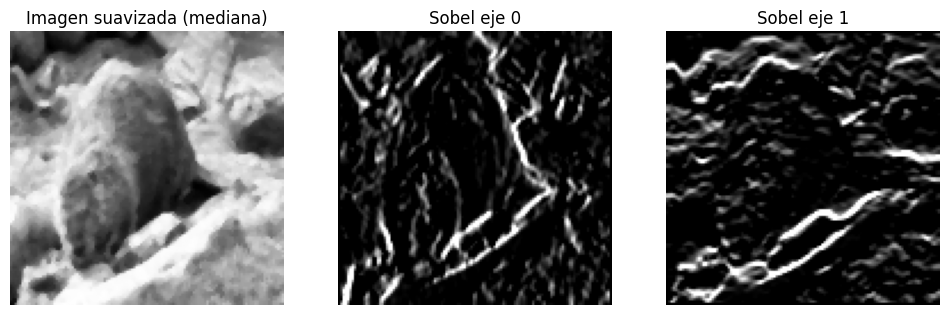

In [9]:
# Ejemplo rápido: filtro Sobel y mediana
random_dir = random.choice(list(image_dict.keys()))
images = image_dict[random_dir]
random_image = random.choice(images).resize((120, 120))
gray_image = np.array(random_image.convert("L"))
blured_image = medi(gray_image, size=3)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.imshow(blured_image, cmap="gray")
plt.title("Imagen suavizada (mediana)")
plt.axis('off')
sobel_image0 = cv2.Sobel(blured_image, ddepth=cv2.CV_8U, dx=1,dy=0,ksize=3)
plt.subplot(1, 3, 2)
plt.imshow(sobel_image0, cmap='gray')
plt.title('Sobel eje 0')
plt.axis('off')
sobel_image1 = cv2.Sobel(blured_image, ddepth=cv2.CV_8U, dx=0,dy=1,ksize=3)
plt.subplot(1, 3, 3)
plt.imshow(sobel_image1, cmap='gray')
plt.title('Sobel eje 1')
plt.axis('off')
plt.show()

![Local Image](./atten.png)

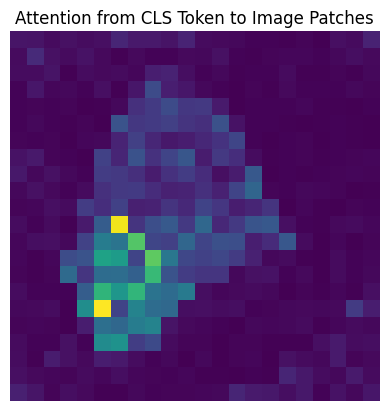

In [10]:
# Extract attention from the last layer
image_resized = resize_transform(random_image)
image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
image_resized = image_resized.unsqueeze(0).cpu()
model.cpu()
outputs = model(image_resized, output_hidden_states=True, output_attentions=True)
attentions = outputs.attentions[-1]  # [batch, heads, tokens, tokens]
attention_map = attentions.mean(dim=1)[0]  # average over heads

# CLS token attention to patches
cls_attention = attention_map[0, 1:]  # exclude CLS token itself
num_patches = int(cls_attention.shape[0] ** 0.5)
cls_attention = cls_attention.reshape(num_patches, num_patches)
cls_attention = cls_attention.detach()

# Plot
plt.imshow(cls_attention.numpy(), cmap="viridis")
plt.title("Attention from CLS Token to Image Patches")
plt.axis("off")
plt.show()

In [11]:
model = AutoModel.from_pretrained(
    ('dinov3-vitb16-pretrain-lvd1689m_offline'),
)
model.cuda()

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-11): 12 x DINOv3ViTLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=768, out_features=3072, bias=True)
        (down_proj): Linear(in_features=3072, out_features=768, bias=True)
        (act_fn): GELUActivation()
 

In [12]:
gallery_features = []
images_list = []

for _ in tqdm(range(50)):
    random_dir = random.choice(list(image_dict.keys()))
    images = image_dict[random_dir]
    random_image = random.choice(images).resize((120, 120))
    images_list.append(random_image)
    gallery_features.append(extract_classification_token(random_image))  # H, W, D

100%|██████████| 50/50 [00:01<00:00, 31.40it/s]


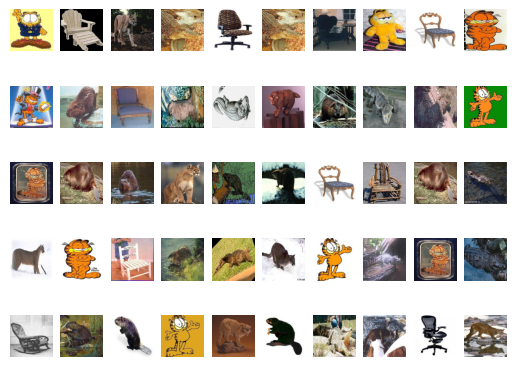

In [13]:
# %%
# visualize random_images
for i, img in enumerate(images_list):
    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.axis("off")

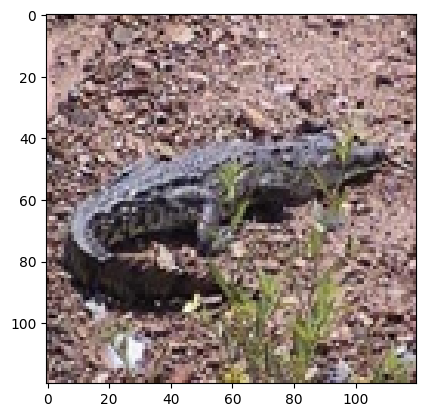

In [14]:
random_dir = random.choice(list(image_dict.keys()))
images = image_dict[random_dir]
random_query_image = random.choice(images).resize((120, 120))
plt.imshow(random_query_image)
query_feature = extract_classification_token(random_query_image)

In [15]:
query_feature,  query_feature.shape


(tensor([ 7.4837e-04,  8.5343e-02,  5.1588e-02,  3.9352e-02,  2.5131e-02,
         -7.8588e-03, -1.1624e-02, -3.6019e-02, -2.7503e-02,  3.7850e-02,
          1.4454e-03, -2.0152e-02, -3.8154e-02, -1.2400e-01, -1.4235e-02,
         -2.0411e-02,  8.9538e-03, -2.9696e-03,  2.3774e-02, -4.5645e-02,
         -3.1788e-02,  1.5478e-02, -2.8748e-02,  6.1100e-02,  6.1603e-02,
         -1.3653e-02, -5.2398e-02, -1.8623e-02, -1.6147e-02,  3.6007e-02,
         -7.5900e-03,  1.0026e-01, -3.2913e-02,  4.5582e-02, -1.7831e-02,
          1.7668e-02,  1.5126e-02,  1.2102e-01, -5.5258e-03, -1.6270e-02,
          4.4335e-02, -3.0428e-03, -2.0060e-02,  5.0420e-03,  7.3199e-03,
         -5.3243e-03, -4.0441e-02, -6.1728e-02,  2.9894e-02, -3.2807e-02,
          4.4772e-02, -1.9220e-02, -9.8377e-03,  2.7179e-03,  4.3175e-02,
          2.3639e-02,  2.2172e-02,  6.0194e-02, -1.2144e-03, -2.0791e-02,
          3.7270e-02,  3.6408e-02,  4.0371e-02,  3.7236e-02, -9.4765e-03,
         -7.9805e-03, -1.8054e-02,  1.

In [16]:
# %%
ordered_similarities = []
for i in tqdm(range(len(gallery_features))):
    sim = cosine_similarity(
        gallery_features[i].unsqueeze(0),  # [1, D]
        query_feature.unsqueeze(0),  # [1, D]
    )
    ordered_similarities.append(sim.squeeze())
ordered_indices = np.argsort(-np.array(ordered_similarities))  # descending order

100%|██████████| 50/50 [00:00<00:00, 5178.92it/s]


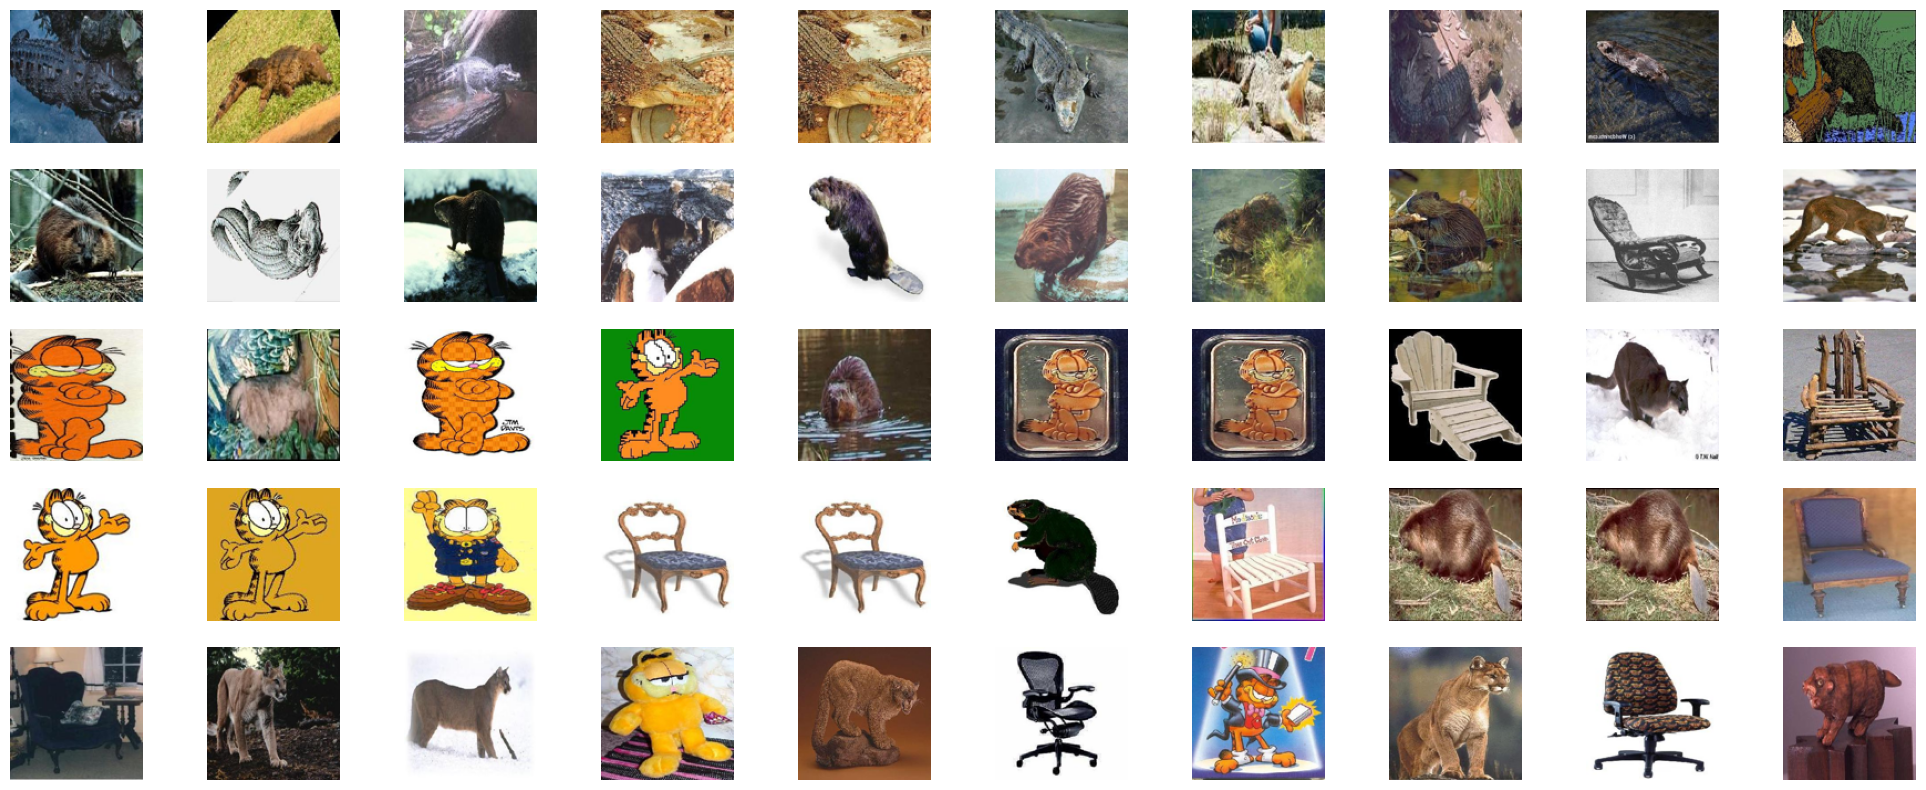

In [17]:
plt.figure(figsize=(25, 10))
for n, i in enumerate(ordered_indices):
    plt.subplot(5, 10, n + 1)
    plt.imshow(images_list[i])
    plt.axis("off")